# Preprocess Data to Create New Dataset

Currently, fast.ai does not have support for audio, so it is a good idea to represent our audio data as an image.

## Setup

### Import necessary libraries

In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import soundfile as sf #used to load sound files
import matplotlib.pyplot as plt #used to plot in notebook
import scipy
from scipy.signal import hann
from scipy.fftpack import rfft

import pandas as pd
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import os
import torch;
import torchaudio;

### Check if CUDA is available - This will be a problem later if this doesn't work

In [2]:
print(torch.cuda.is_available())

True


### Setup dataset paths

In [3]:
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
SAMPLE_DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'sample_data'))

DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')
path = Path(DATA_ROOT_DIR)

References for below: https://www.kaggle.com/code/servietsky/fast-import-audio-and-save-spectrograms

### Convert to Spectrograms and Save New Dataset

In [418]:
def create_mel_spectrogram(audio):
    audio, sample_rate = librosa.core.load(audio)
    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, fmax=sample_rate/2, center=False)
    
    # Normalize to decibals
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sample_rate

def create_spectrogram(audio):
    audio, sample_rate = librosa.core.load(audio)

    # Compute spectrogram
    D = librosa.stft(audio, center=False)  # STFT of y
    
    # Normalize to decibals
    S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_dB, sample_rate




Check one file to see if data loaded correctly

(1025, 83)
Specgram Size: (1025, 83)
Mel Specgram Size: (128, 83)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


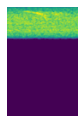

In [426]:
import librosa
import numpy

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_to_image(spectrogram):
    spectrogram = np.log(spectrogram + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(spectrogram, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    return img
    
files = get_files(path)
audio_file = files[0]

spec, sample_rate = create_spectrogram(audio_file)
mel_spec, sample_rate = create_mel_spectrogram(audio_file)


show_image(spectrogram_to_image(spec))
new_p = PILImage.create(fft_p).convert("RGB")
mel_image = PILImage.create(mel_spec, mode="RGB")

print(spec_image.shape)

show_image(spec_image)
show_image(mel_image)
print(f"Specgram Size: {spec_image.shape}")
print(f"Mel Specgram Size: {mel_image.shape}")

Preview results of CropImageTransform

Specgram Size: (128, 83)
Mel Specgram Size: (128, 83)


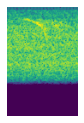

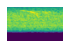

In [405]:
tfm = CropImageTransform(lower=128)
cropped_spec = tfm((spec_image))
show_image(cropped_spec);
print(f"Specgram Size: {cropped_spec.shape}")

# crop amount for mel spectrograms needs to be adjusted, inherently compressed
tfm = CropImageTransform(lower=50)
cropped_mel_spec = tfm((mel_image))
show_image(cropped_mel_spec);
print(f"Mel Specgram Size: {cropped_spec.shape}")

## Model Training

### Load dataset

In [406]:
dblock = DataBlock(
    blocks = [TransformBlock, CategoryBlock],
    get_items = get_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = [ SpecgramTransform(), CropImageTransform(lower=128), RatioResize(224), CropPad(224) ]
)
dls = dblock.dataloaders(path)
dls.show_batch(max_n=20)
image = dls.one_batch()[0][0]
print(image.shape)
show_image(image)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


TypeError: Cannot handle this data type: (1, 1, 3), <f4

### Train

In [398]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)
learn.fit(10)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1025, 83, 3] to have 3 channels, but got 1025 channels instead

### Export

In [ ]:
TODO: by you

## Brainstorm ideas for improvement

Don't improve things in this notebook. Save it for the later one. But just jot down some ideas you can think of to improve the results.

* todo by you